## Setup

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits

In [4]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
sns.set_style('darkgrid')

In [5]:
digits_data, digits_target = load_digits(as_frame=True, return_X_y=True)
digits_data

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


## Visualize Pixels

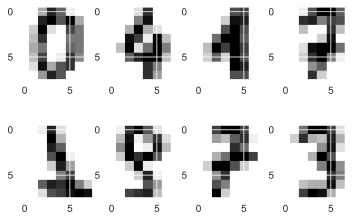

In [6]:
selected_rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]

fig = plt.figure()

for idx, row in enumerate(selected_rows):
    ax = fig.add_subplot(2, 4, idx+1)
    pixels = digits_data.iloc[[row]]
    image = pixels.values.reshape(8, 8)
    ax.imshow(image, cmap='gray_r')
    
plt.show()

### Train / Test Helpers

In [198]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [8]:
def train(model, index):
    model.fit(digits_data.iloc[index], digits_target.iloc[index])
    return model

In [222]:
def test(model, index):
    predictions = model.predict(digits_data.iloc[index])
    return accuracy_score(digits_target.iloc[index], predictions)

In [10]:
def cross_validate(model, k_folds, predict_train = False):
    kf = KFold(k_folds, shuffle=True, random_state=200)
    folds_idx_lists = kf.split(digits_data)
    
    scores = []
    for train_idx, test_idx in folds_idx_lists:
        model = train(model, train_idx)
        score = test(model, train_idx if predict_train else test_idx)
        scores.append(score)
        
    return np.mean(scores)

In [190]:
def train_test(model_class, k_folds = 6, param = (None, None), predict_train = False, **kwargs):
    param_name, param_values = param
    if not (model_class and param_name and param_values):
        return

    results = []
    for param_value in param_values:
        
        model_args = kwargs
        model_args[param_name] = param_value
        model = model_class(**model_args)
        
        model_name = type(model).__name__
        result = {
            'model': model_name,
            'param_name': param_name, 
            'param': param_value,
            'predict_train': predict_train,
            'accuracy': cross_validate(model, k_folds, predict_train = predict_train),
        }
        results.append(result)
    
    return pd.DataFrame(results)

#### Results Helpers

In [142]:
def plot_results(results, groupby, subtitle='', **kwargs):
    title = results.iloc[0]['model']
    param_name = results.iloc[0]['param_name']
    
    ax = plt.gca()
    ax.set_title(title + '\n' + subtitle)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(param_name)
    
    if groupby:
        for group, data in results.groupby(groupby):
            label = groupby + ': ' + str(group)
            ax.plot('param', 'accuracy', data=data, label='_nolegend_', alpha=0.7, linewidth=0.5)
            ax.scatter('param', 'accuracy', data=data, label=label, **kwargs)
        plt.legend()
    else:
        ax.scatter('param', 'accuracy', data=results, **kwargs)
    
    plt.show()

In [166]:
def structure_results(results):
  test_results = results[~results['predict_train']].reset_index(drop=True)
  train_results = results[results['predict_train']].reset_index(drop=True)

  results = test_results.join(train_results['accuracy'], rsuffix='_train')
  results['overfit'] = (1 - results['accuracy'] / results['accuracy_train']).map('{:.2%}'.format)

  cols = ['model', 'param_name', 'param', 'accuracy', 'accuracy_train', 'overfit']
  return results[cols].sort_values('accuracy', ascending=False)

## K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [167]:
ks = range(1,10)
model = KNeighborsClassifier

results_knn = pd.DataFrame()
%store -r results_knn

if results_knn.empty:
  results_knn_test = train_test(model, param=('n_neighbors', ks))
  results_knn_train = train_test(model, param=('n_neighbors', ks), predict_train=True)
  
  results_knn = pd.concat([
      results_knn_test,
      results_knn_train,
  ])

  %store results_knn

structure_results(results_knn)

,model,param_name,param,accuracy,accuracy_train,overfit
2,KNeighborsClassifier,n_neighbors,3,0.988313,0.993545,0.53%
0,KNeighborsClassifier,n_neighbors,1,0.987198,1.000000,1.28%
4,KNeighborsClassifier,n_neighbors,5,0.986643,0.991096,0.45%
5,KNeighborsClassifier,n_neighbors,6,0.986087,0.988314,0.23%
3,KNeighborsClassifier,n_neighbors,4,0.985528,0.991541,0.61%
6,KNeighborsClassifier,n_neighbors,7,0.985528,0.989427,0.39%
1,KNeighborsClassifier,n_neighbors,2,0.984970,0.991208,0.63%
8,KNeighborsClassifier,n_neighbors,9,0.984417,0.987757,0.34%
7,KNeighborsClassifier,n_neighbors,8,0.983302,0.987201,0.39%


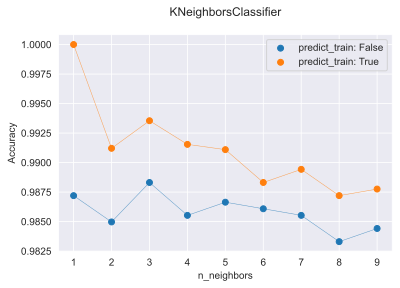

In [159]:
plot_results(results_knn, groupby='predict_train')

## Neural Network

In [160]:
from sklearn.neural_network import MLPClassifier

### 1 Hidden Layer

In [246]:
layer_sizes = [(ns,) for ns in [8, 16, 32, 64, 128, 256]]
model = MLPClassifier

params_nn_1hl = {
  'random_state': 1,
  'param': ('hidden_layer_sizes', layer_sizes)
}

results_nn_single_layer = pd.DataFrame()
%store -r results_nn_single_layer

if results_nn_single_layer.empty:
  results_nn_test = train_test(model, **params_nn_1hl)
  results_nn_train = train_test(model, predict_train=True, **params_nn_1hl)

  results_nn_single_layer = pd.concat([
    results_nn_train,
    results_nn_test
  ])
  %store results_nn_single_layer

structure_results(results_nn_single_layer)

,model,param_name,param,accuracy,accuracy_train,overfit
5,MLPClassifier,hidden_layer_sizes,"(256,)",0.982752,1.000000,1.72%
4,MLPClassifier,hidden_layer_sizes,"(128,)",0.973839,1.000000,2.62%
3,MLPClassifier,hidden_layer_sizes,"(64,)",0.969952,1.000000,3.00%
2,MLPClassifier,hidden_layer_sizes,"(32,)",0.966057,0.999666,3.36%
1,MLPClassifier,hidden_layer_sizes,"(16,)",0.954916,0.996773,4.20%
0,MLPClassifier,hidden_layer_sizes,"(8,)",0.826955,0.865553,4.46%


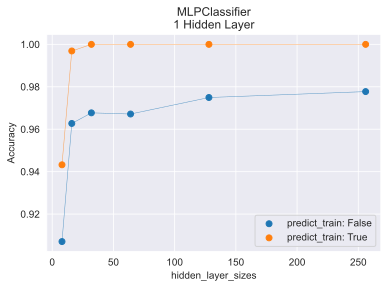

In [180]:
nn_plot_data = results_nn_single_layer.copy()
nn_plot_data['param'] = nn_plot_data['param'].apply(lambda val: val[0])
plot_results(nn_plot_data, groupby='predict_train', subtitle='1 Hidden Layer')

### 2 Hidden Layers

In [249]:
layer_sizes = [(64,64), (128, 128)]
model = MLPClassifier

params_nn_2hl = {
  'random_state': 1,
  'param': ('hidden_layer_sizes', layer_sizes)
}


results_nn_two_layers = pd.DataFrame()
%store -r results_nn_two_layers

if results_nn_two_layers.empty:
  results_nn_train = train_test(model, predict_train=True, **params_nn_2hl)
  results_nn_test = train_test(model, **params_nn_2hl)

  results_nn_two_layers = pd.concat([
      results_nn_train,
      results_nn_test
  ])

  %store results_nn_two_layers

structure_results(results_nn_two_layers)

,model,param_name,param,accuracy,accuracy_train,overfit
1,MLPClassifier,hidden_layer_sizes,"(128, 128)",0.980522,1.0,1.95%
0,MLPClassifier,hidden_layer_sizes,"(64, 64)",0.973291,1.0,2.67%


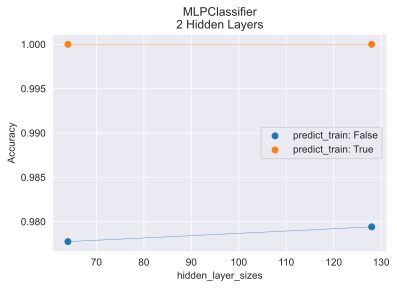

In [183]:
nn_plot_data = results_nn_two_layers.copy()
nn_plot_data['param'] = nn_plot_data['param'].apply(lambda val: val[0])
plot_results(nn_plot_data, groupby='predict_train', subtitle='2 Hidden Layers')

### 3 Hidden Layers

In [251]:
layer_sizes = [(ns, ns, ns) for ns in [10, 64, 128]]
model = MLPClassifier

params_nn_3hl = {
  'random_state': 1,
  'param': ('hidden_layer_sizes', layer_sizes)
}


results_nn_three_layers = pd.DataFrame()
%store -r results_nn_three_layers

if results_nn_three_layers.empty:
  results_nn_train = train_test(model, predict_train=True, **params_nn_3hl)
  results_nn_test = train_test(model, **params_nn_3hl)
  results_nn_three_layers = pd.concat([
      results_nn_train,
      results_nn_test
  ])

  %store results_nn_three_layers

structure_results(results_nn_three_layers)

,model,param_name,param,accuracy,accuracy_train,overfit
2,MLPClassifier,hidden_layer_sizes,"(128, 128, 128)",0.981078,1.000000,1.89%
1,MLPClassifier,hidden_layer_sizes,"(64, 64, 64)",0.975511,1.000000,2.45%
0,MLPClassifier,hidden_layer_sizes,"(10, 10, 10)",0.949928,0.996327,4.66%


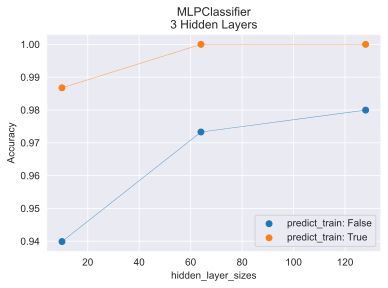

In [179]:
nn_plot_data = results_nn_three_layers.copy()
nn_plot_data['param'] = nn_plot_data['param'].apply(lambda val: val[0])
plot_results(nn_plot_data, groupby='predict_train', subtitle='3 Hidden Layers')

## Model Comparison: K-Nearest Neighbours / Neural Network

### Compare Accuracy and Overfitting

In [254]:
results_knn_nn = pd.concat([results_knn, results_nn_single_layer, results_nn_two_layers, results_nn_three_layers])
structure_results(results_knn_nn)

,model,param_name,param,accuracy,accuracy_train,overfit
2,KNeighborsClassifier,n_neighbors,3,0.988313,0.993545,0.53%
0,KNeighborsClassifier,n_neighbors,1,0.987198,1.000000,1.28%
4,KNeighborsClassifier,n_neighbors,5,0.986643,0.991096,0.45%
5,KNeighborsClassifier,n_neighbors,6,0.986087,0.988314,0.23%
3,KNeighborsClassifier,n_neighbors,4,0.985528,0.991541,0.61%
6,KNeighborsClassifier,n_neighbors,7,0.985528,0.989427,0.39%
1,KNeighborsClassifier,n_neighbors,2,0.984970,0.991208,0.63%
8,KNeighborsClassifier,n_neighbors,9,0.984417,0.987757,0.34%
7,KNeighborsClassifier,n_neighbors,8,0.983302,0.987201,0.39%
14,MLPClassifier,hidden_layer_sizes,"(256,)",0.982752,1.000000,1.72%


## Decision Tree

In [186]:
from sklearn.tree import DecisionTreeClassifier

In [242]:
depths = [4, 16, 32, 64, 128, 256]
model = DecisionTreeClassifier

results_dt = pd.DataFrame()
%store -r results_dt

dt_params = {
  'random_state': 1,
  'min_samples_split': 2,
  'param': ('max_depth', depths)
}


if results_dt.empty:
  results_dt_train = train_test(model, predict_train=True, **dt_params)
  results_dt_test = train_test(model, **dt_params)
  results_dt = pd.concat([
      results_dt_train,
      results_dt_test
  ])

  %store results_dt

structure_results(results_dt)

,model,param_name,param,accuracy,accuracy_train,overfit
1,DecisionTreeClassifier,max_depth,16,0.851977,1.000000,14.80%
2,DecisionTreeClassifier,max_depth,32,0.851977,1.000000,14.80%
3,DecisionTreeClassifier,max_depth,64,0.851977,1.000000,14.80%
4,DecisionTreeClassifier,max_depth,128,0.851977,1.000000,14.80%
5,DecisionTreeClassifier,max_depth,256,0.851977,1.000000,14.80%
0,DecisionTreeClassifier,max_depth,4,0.573168,0.610357,6.09%


## Random Forest

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [255]:
dephts = np.arange(6, 40, 4).tolist()
model = RandomForestClassifier

results_rf = pd.DataFrame()
%store -r results_rf

rf_params = {
  'random_state': 1,
  'n_estimators': 200,
  'param': ('max_depth', dephts)
}

if results_rf.empty:
  results_rf_train = train_test(model, predict_train=True, **rf_params)
  results_rf_test = train_test(model, **rf_params)
  results_rf = pd.concat([
      results_rf_train,
      results_rf_test
  ])

  %store results_rf

structure_results(results_rf)

,model,param_name,param,accuracy,accuracy_train,overfit
3,RandomForestClassifier,max_depth,18,0.978289,1.000000,2.17%
4,RandomForestClassifier,max_depth,22,0.978289,1.000000,2.17%
5,RandomForestClassifier,max_depth,26,0.978289,1.000000,2.17%
6,RandomForestClassifier,max_depth,30,0.978289,1.000000,2.17%
7,RandomForestClassifier,max_depth,34,0.978289,1.000000,2.17%
8,RandomForestClassifier,max_depth,38,0.978289,1.000000,2.17%
1,RandomForestClassifier,max_depth,10,0.977733,1.000000,2.23%
2,RandomForestClassifier,max_depth,14,0.977178,1.000000,2.28%
0,RandomForestClassifier,max_depth,6,0.953809,0.985086,3.18%


## Model Comparison: Decision Tree / Random Forest

### Compare Accuracy and Overfitting

In [256]:
results_dt_rf = pd.concat([results_dt, results_rf])
structure_results(results_dt_rf)

,model,param_name,param,accuracy,accuracy_train,overfit
9,RandomForestClassifier,max_depth,18,0.978289,1.000000,2.17%
10,RandomForestClassifier,max_depth,22,0.978289,1.000000,2.17%
11,RandomForestClassifier,max_depth,26,0.978289,1.000000,2.17%
12,RandomForestClassifier,max_depth,30,0.978289,1.000000,2.17%
13,RandomForestClassifier,max_depth,34,0.978289,1.000000,2.17%
14,RandomForestClassifier,max_depth,38,0.978289,1.000000,2.17%
7,RandomForestClassifier,max_depth,10,0.977733,1.000000,2.23%
8,RandomForestClassifier,max_depth,14,0.977178,1.000000,2.28%
6,RandomForestClassifier,max_depth,6,0.953809,0.985086,3.18%
1,DecisionTreeClassifier,max_depth,16,0.851977,1.000000,14.80%


## Model Comparison: All Models

In [257]:
results_all_models = pd.concat([results_knn_nn, results_dt_rf])
structure_results(results_all_models)

,model,param_name,param,accuracy,accuracy_train,overfit
2,KNeighborsClassifier,n_neighbors,3,0.988313,0.993545,0.53%
0,KNeighborsClassifier,n_neighbors,1,0.987198,1.000000,1.28%
4,KNeighborsClassifier,n_neighbors,5,0.986643,0.991096,0.45%
5,KNeighborsClassifier,n_neighbors,6,0.986087,0.988314,0.23%
3,KNeighborsClassifier,n_neighbors,4,0.985528,0.991541,0.61%
6,KNeighborsClassifier,n_neighbors,7,0.985528,0.989427,0.39%
1,KNeighborsClassifier,n_neighbors,2,0.984970,0.991208,0.63%
8,KNeighborsClassifier,n_neighbors,9,0.984417,0.987757,0.34%
7,KNeighborsClassifier,n_neighbors,8,0.983302,0.987201,0.39%
14,MLPClassifier,hidden_layer_sizes,"(256,)",0.982752,1.000000,1.72%
